In [66]:
from typing import Literal
from typing_extensions import TypedDict, List
import os 

# 서드파티 라이브러리
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, START, END, MessagesState
from pyzerox import zerox

# LangChain 관련 라이브러리
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import (
    PyPDFLoader,
    UnstructuredMarkdownLoader,
    TextLoader,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
import markdown
from bs4 import BeautifulSoup
from datetime import date
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langchain_core.messages import RemoveMessage, HumanMessage, SystemMessage
load_dotenv()

True

In [2]:
MODEL_NAME = "gemma2-9b-it"

llm = ChatGroq(model_name=MODEL_NAME)
small_llm = ChatGroq(model_name=MODEL_NAME)
router_llm = ChatGroq(model_name=MODEL_NAME)


In [3]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [5]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [6]:
from langchain_core.tools.retriever import create_retriever_tool

In [7]:
embeddings_model = HuggingFaceEmbeddings(
    model_name='jhgan/ko-sroberta-nli',
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings':True},
)



#이미 생성된 크로마 db 가져오기
vector_store = Chroma(
    embedding_function=embeddings_model,
    collection_name = "income_tax_collection",
    persist_directory = "./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs = {"k":3})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)

C:\Users\user\AppData\Local\Temp\ipykernel_21476\730275842.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(
c:\USERS\USER\DESKTOP\FINBRAINAGENT\VENV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from langgraph.prebuilt import ToolNode

tool_list = [ search_tool, retriever_tool]  + loaded_tool_list
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [11]:
def agent(state: MessagesState) -> MessagesState:
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [12]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
)
graph_builder.add_edge('tools', 'agent')

graph= graph_builder.compile()

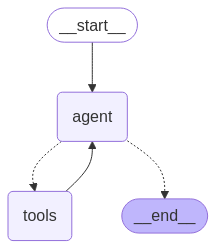

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
query = '집이 1000만원일때 종합부동산세 계산해줄수있냐'
graph.invoke({"messages":query})

{'messages': [HumanMessage(content='집이 1000만원일때 종합부동산세 계산해줄수있냐', additional_kwargs={}, response_metadata={}, id='16c9dcc2-ed41-49ae-a80d-a11142206cb9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_c28z', 'function': {'arguments': '{"query":"종합부동산세 계산 1000만원"}', 'name': 'real_estate_tax_retriever'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 1282, 'total_tokens': 1383, 'completion_time': 0.183636364, 'prompt_time': 0.04467853, 'queue_time': 0.022475627000000005, 'total_time': 0.228314894}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-049e0a38-a3be-4a90-9db6-fbf22f0ff542-0', tool_calls=[{'name': 'real_estate_tax_retriever', 'args': {'query': '종합부동산세 계산 1000만원'}, 'id': 'call_c28z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1282, 'output_tokens': 101, 'total_tokens': 1383}),
  ToolMessage(content='제94조제1항제3호 및 목록

In [17]:
from langchain_core.messages import HumanMessage

query = '집이 1000만원일때 종합부동산세 계산해줄수있냐'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 1000만원일때 종합부동산세 계산해줄수있냐
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_5b18)
 Call ID: call_5b18
  Args:
    query: 종합부동산세 계산 1000만원
================================= Tool Message =================================
Name: real_estate_tax_retriever

제94조제1항제3호 및 목록에 따른 자산 중 제104조의3에 따른 비사업용 토지의 보유 현황을 고려하여 대통령령으로 정하는 자산

소득세법
양도소득 과세표준
|       구간        |      세율       |
|:------------------:|:---------------:|
| 1,400만원 이하     |        16%      |
| 2,400만원 초과    | 22,204,000원 + (1,400만원 초과액 × 25% 세율) |
| 5,000만원 이하     | 1,124,000원 + (5,000만원 초과액 × 34% 세율) |
| 8,800만원 이하     | 5,206,000원 + (8,800만원 초과액 × 38% 세율) |
| 14,500만원 이하    | 5,206,000원 + (1,500만원 초과액 × 40% 세율) |
| 3,000만원 초과     | 12,406,000원 + (3,000만원 초과액 × 50% 세율) |
| 5,000만원 초과     | 12,406,000원 + (5,000만원 초과액 × 52% 세율) |
| 10,000만원 초과    | 48,406,000원 + (10억원 초과액

In [21]:
query = 'Chain of Thought 논문을 요약해라'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Chain of Thought 논문을 요약해라
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_rjsj)
 Call ID: call_rjsj
  Args:
    query: Chain of Thought Prompting
================================= Tool Message =================================
Name: arxiv

Published: 2023-01-10
Title: Chain-of-Thought Prompting Elicits Reasoning in Large Language Models
Authors: Jason Wei, Xuezhi Wang, Dale Schuurmans, Maarten Bosma, Brian Ichter, Fei Xia, Ed Chi, Quoc Le, Denny Zhou
Summary: We explore how generating a chain of thought -- a series of intermediate
reasoning steps -- significantly improves the ability of large language models
to perform complex reasoning. In particular, we show how such reasoning
abilities emerge naturally in sufficiently large language models via a simple
method called chain of thought prompting, where a few chain of thought
demonstrations are pro

In [22]:
query = '트럼프의 최근 관세 정책에 대해 알려줘'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

트럼프의 최근 관세 정책에 대해 알려줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_tm2n)
 Call ID: call_tm2n
  Args:
    query: trump recent tariff policies
================================= Tool Message =================================
Name: duckduckgo_search

President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted approach.. In October 2022, he issues sweeping new restrictions on selling semiconductors and chipmaking equipment to China. These curbs will be expanded in October 2023 and December 2024 — when China responds with a ban of U.S. exports for ... NEW YORK (AP) — U.S. President Donald Trump's long-threatened tariffs are here, plunging the country into an escalating trade war with China, Canada and Mexico. Trump's 25% tariffs on imports from Can

# 체크포인트 추가

In [23]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
)
graph_builder.add_edge('tools', 'agent')



In [26]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph= graph_builder.compile(
    checkpointer=checkpointer
)


### 스레드 관리

In [27]:
config = {
    'configurable':{
        'thread_id': 'paper_summary'
    }
}

query = '트럼프의 최근 관세 정책에 대해 알려줘'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

트럼프의 최근 관세 정책에 대해 알려줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_aw0r)
 Call ID: call_aw0r
  Args:
    query: trump recent tariff policy
================================= Tool Message =================================
Name: duckduckgo_search

Tariffs under Biden. President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted approach.. In October 2022, he issues sweeping new restrictions on selling semiconductors and chipmaking equipment to China. These curbs will be expanded in October 2023 and December 2024 — when China responds with a ban ... The European Union, for example, punched back against Trump's tariffs on steel and aluminum by taxing U.S. products, from bourbon to Harley-Davidson motorcycles. Likewise, China responded to Trump's tr

In [28]:
update_query = '정책 출처 url을 첨부해라'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

정책 출처 url을 첨부해라라
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_28dq)
 Call ID: call_28dq
  Args:
    query: sources for trump tariff policy
================================= Tool Message =================================
Name: duckduckgo_search

WASHINGTON (AP) — To President Donald Trump, "tariff" is more than "the most beautiful word in the dictionary," something he says often.. Tariffs, in Trump's view, are also a cure for a number of the nation's ills and the tool to reach new heights.. Most economists see taxes paid on imports as capable of addressing unfair trade practices, but they're skeptical of the quasi ... Here's a full list of dates, products and levies proposed by the president: Feb. 4. President Trump imposed a 10 percent tariff on all imports from China including medicine, metals and machinery. NEW YORK (AP) — U.S. Pr

In [29]:
update_query = '내용이 좋네 핵심을 요약해라'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

내용이 좋네 핵심을 요약해라
================================== Ai Message ==================================

The text describes Trump's tariff policy, highlighting his belief in tariffs as a solution to trade imbalances and his implementation of tariffs on goods from China, Canada, and Mexico.  

It also mentions the economic debates surrounding tariffs and Trump's use of Section 232 of the Trade Expansion Act of 1962 to impose tariffs on steel and aluminum imports.  

However, the text itself doesn't provide specific source citations for the information presented.


### 메시지 히스토리 관리 방법
1. 초반 메시지 삭제 (removemessage / node 사용해서 삭제)
2. 초반 메시지 삭제 말고 요약

##### removeMessage

In [33]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[HumanMessage(content='트럼프의 최근 관세 정책에 대해 알려줘', additional_kwargs={}, response_metadata={}, id='45a08885-911e-4d2b-bb9e-82a2772c1d10'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aw0r', 'function': {'arguments': '{"query":"trump recent tariff policy"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1273, 'total_tokens': 1360, 'completion_time': 0.158181818, 'prompt_time': 0.05511921, 'queue_time': 0.022372604000000004, 'total_time': 0.213301028}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0e8ea330-7c61-4105-9e87-426ca5908721-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'trump recent tariff policy'}, 'id': 'call_aw0r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1273, 'output_tokens': 87, 'total_tokens': 1360}),
 ToolMessage(content="Tariffs under Biden. President Jo

In [34]:
from langchain_core.messages import RemoveMessage

for index, message in enumerate(current_message_list):
    if index < len(current_message_list)-1:
        graph.update_state(config, {'messages' : RemoveMessage(id=message.id)})

In [35]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content="The text describes Trump's tariff policy, highlighting his belief in tariffs as a solution to trade imbalances and his implementation of tariffs on goods from China, Canada, and Mexico.  \n\nIt also mentions the economic debates surrounding tariffs and Trump's use of Section 232 of the Trade Expansion Act of 1962 to impose tariffs on steel and aluminum imports.  \n\nHowever, the text itself doesn't provide specific source citations for the information presented.  \n\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 2308, 'total_tokens': 2408, 'completion_time': 0.181818182, 'prompt_time': 0.105815217, 'queue_time': 0.022213522, 'total_time': 0.287633399}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-9a5ebd35-b21f-4ab1-8603-e6931c692d0f-0', usage_metadata={'input_tokens': 2308, 'output_tokens': 100, 'total_tokens': 2408})]

remove Node

In [41]:
def delete_messages(state:MessagesState):
    messages = state['messages']
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    return {'messages' : delete_messages}

def shoud_continue(state:MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return 'tools'
    return 'delete_messages'



In [42]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_messages)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    shoud_continue,
    ['tools', 'delete_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('delete_messages', END)


checkpointer = MemorySaver()

graph= graph_builder.compile(
    checkpointer=checkpointer
)


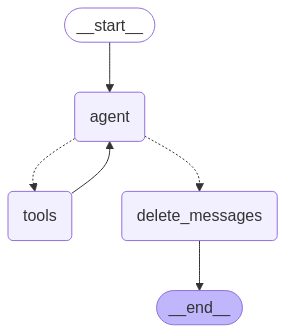

In [43]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [44]:
config = {
    'configurable':{
        'thread_id': 'paper_summary2'
    }
}

query = '트럼프의 최근 관세 정책에 대해 알려줘'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

트럼프의 최근 관세 정책에 대해 알려줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_9sc4)
 Call ID: call_9sc4
  Args:
    query: trump recent tariff policy
================================= Tool Message =================================
Name: duckduckgo_search

Tariffs under Biden. President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted approach.. In October 2022, he issues sweeping new restrictions on selling semiconductors and chipmaking equipment to China. These curbs will be expanded in October 2023 and December 2024 — when China responds with a ban ... In March 2018, President Trump invoked authority under Section 232 of the Trade Expansion Act of 1962 (19 U.S.C. § 1862) to impose 25% tariffs on steel imports and 10% tariffs on aluminum. Trump, howev

In [45]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9sc4', 'function': {'arguments': '{"query":"trump recent tariff policy"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1273, 'total_tokens': 1360, 'completion_time': 0.158181818, 'prompt_time': 0.061163784, 'queue_time': 0.020386479, 'total_time': 0.219345602}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9b2b71fe-c84b-44d3-b45f-6d84aeff03ad-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'trump recent tariff policy'}, 'id': 'call_9sc4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1273, 'output_tokens': 87, 'total_tokens': 1360}),
 ToolMessage(content="Tariffs under Biden. President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted app

In [46]:
update_query = '내용이 좋네 핵심을 요약해라'
for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

current_message_list = graph.get_state(config).values['messages']
current_message_list

================================ Human Message =================================

내용이 좋네 핵심을 요약해라
================================== Ai Message ==================================

Biden 크게 트럼프 시대 중국의 관세를 유지하며, 집중적인 접근 방식을 채택하고 있습니다.  2022년 10월부터 반도체 및 제조 장비를 중국에 판매하는 데 대한 규제를 시행하며, 2023년 10월과 2024년 12월에 더욱 확대될 예정입니다. 2018년 3월, 트럼프 대통령은 철강 수입에 대해 25%, 알루미늄 수입에 대해 10%의 관세를 부과했습니다.
================================== Ai Message ==================================

Biden 크게 트럼프 시대 중국의 관세를 유지하며, 집중적인 접근 방식을 채택하고 있습니다.  2022년 10월부터 반도체 및 제조 장비를 중국에 판매하는 데 대한 규제를 시행하며, 2023년 10월과 2024년 12월에 더욱 확대될 예정입니다. 2018년 3월, 트럼프 대통령은 철강 수입에 대해 25%, 알루미늄 수입에 대해 10%의 관세를 부과했습니다.


[AIMessage(content='President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted approach.  In October 2022, he issues sweeping new restrictions on selling semiconductors and chipmaking equipment to China. These curbs will be expanded in October 2023 and December 2024 — when China responds with a ban.   In March 2018, President Trump invoked authority under Section 232 of the Trade Expansion Act of 1962 (19 U.S.C. § 1862) to impose 25% tariffs on steel imports and 10% tariffs on aluminum. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 146, 'prompt_tokens': 1670, 'total_tokens': 1816, 'completion_time': 0.265454545, 'prompt_time': 0.05794864, 'queue_time': 0.022454312999999997, 'total_time': 0.323403185}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d566c006-be13-4538-b737-dec163f26e6e-0

### 삭제 말고 요약하기 - > 요약해서 토큰 아끼기

In [71]:
# summary 담을 State 

class AgentSate(MessagesState):
    summary: str


# 요약 노드 
def summarize_messages(state:AgentSate):
    messages= state['messages']
    summary = state['summary']
    summary_prompt = f"sumamrize this chat history bleow : \n\nchat_history:{messages}"

    if summary != "":
        summary_prompt =f"""summarize this chat history below while looking at the summary of earlier conversations
        chat_history:{messages}
        summary:{summary}"""

    
    groq_summary_prompt = ChatPromptTemplate.from_messages([
        ('system', "Write a concise summary of the below context"),
        ('human', "{context}")
    ])

    groq_summary_chain = groq_summary_prompt | small_llm | StrOutputParser()
    summary = small_llm.invoke(summary_prompt)

    response = groq_summary_chain.invoke(messages)
    return {'summary' : response}


def shoud_continue(state:MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return 'tools'
    return 'summarize_messages'


# summary 내용 추가 
def agent(state: AgentSate):
    messages = state['messages']
    summary = state['summary']
    if summary != "":
        messages = [SystemMessage(content=f"Here is the summary of the earlier conversations: {summary}")] + messages
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [72]:
graph_builder = StateGraph(AgentSate)

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    shoud_continue,
    ['tools', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('delete_messages', END)
graph_builder.add_edge('summarize_messages', 'delete_messages')

checkpointer = MemorySaver()

graph= graph_builder.compile(
    checkpointer=checkpointer
)


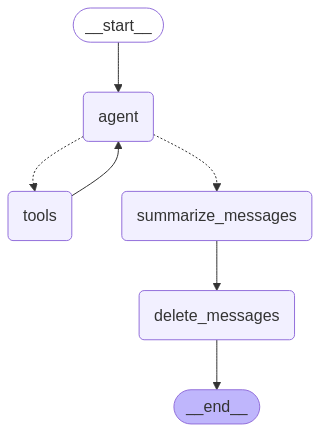

In [73]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [74]:
config = {
    'configurable':{
        'thread_id': 'paper_summary2'
    }
}

query = '트럼프의 최근 관세 정책에 대해 알려줘'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary' : ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

트럼프의 최근 관세 정책에 대해 알려줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_brpk)
 Call ID: call_brpk
  Args:
    query: trump recent tariffs
================================= Tool Message =================================
Name: duckduckgo_search

President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted approach.. In October 2022, he issues sweeping new restrictions on selling semiconductors and chipmaking equipment to China. These curbs will be expanded in October 2023 and December 2024 — when China responds with a ban of U.S. exports for ... A day after offering Canada a one-month reprieve on punishing nearly across-the-board 25% tariffs, President Donald Trump has threatened new tariffs as soon as Friday on Canadian lumber and dairy ... Thursday

In [75]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_brpk', 'function': {'arguments': '{"query":"trump recent tariffs"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1273, 'total_tokens': 1359, 'completion_time': 0.156363636, 'prompt_time': 0.04439614, 'queue_time': 0.021592736, 'total_time': 0.200759776}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bf14fe6d-4380-4490-b600-de202ce25536-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'trump recent tariffs'}, 'id': 'call_brpk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1273, 'output_tokens': 86, 'total_tokens': 1359}),
 ToolMessage(content="President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted approach.. In October 2022, he issues

In [76]:
current_message_list = graph.get_state(config).values['summary']
current_message_list

'This conversation revolves around Donald Trump\'s recent tariff policies.\n\nA user asks about Trump\'s recent tariff policies, prompting the AI to use a tool called "duckduckgo_search" to find relevant information. The tool returns news articles detailing Trump\'s imposition of tariffs on goods from China, Canada, and Mexico, as well as his administration\'s justifications and the resulting trade war.\n\nThe AI then summarizes the key points, noting that President Joe Biden largely maintains Trump\'s tariffs on China but adopts a more targeted approach. \n\n\n'

In [77]:
config = {
    'configurable':{
        'thread_id': 'paper_summary2'
    }
}

query = '트럼프의 최근 관세 정책에서 핵심 키워드 하나만 뽑아봐'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary' : ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

트럼프의 최근 관세 정책에서 핵심 키워드 하나만 뽑아봐
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_zqrs)
 Call ID: call_zqrs
  Args:
    query: trump recent tariffs
================================= Tool Message =================================
Name: duckduckgo_search

A day after offering Canada a one-month reprieve on punishing nearly across-the-board 25% tariffs, President Donald Trump has threatened new tariffs as soon as Friday on Canadian lumber and dairy ... Trump's Republican administration has insisted that its new tariffs would equalize the ability of U.S. and foreign manufacturers to compete, though under current law these new taxes would likely be paid by American consumers and businesses either directly or in the form of higher prices. The rates to be charged would be studied over the weeks ... Trump had previously threatened to place a 25% 

In [78]:
current_message_list = graph.get_state(config).values['summary']
current_message_list

'This conversation explores Trump\'s recent tariff policies. \n\nIt starts with a query about Trump\'s recent tariffs, triggering a tool call to DuckDuckGo Search. The response summarizes Biden\'s continuation of most of Trump\'s tariffs on China, while emphasizing a more targeted approach. \n\nFurther interactions focus on identifying key keywords related to Trump\'s tariffs, again utilizing DuckDuckGo Search. The keyword "China" emerges as a central theme. \n\n\nThe conversation highlights the ongoing impact of Trump\'s trade policies and the subsequent actions taken by the Biden administration. \n'

In [79]:
config = {
    'configurable':{
        'thread_id': 'paper_summary2'
    }
}

query = '트럼프 관세 정책이 주식시장에 끼치는 영향은 뭐야'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary' : ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

트럼프 관세 정책이 주식시장에 끼치는 영향은 뭐야
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_0exj)
 Call ID: call_0exj
  Args:
    query: impact of tariffs on stock market
================================= Tool Message =================================
Name: arxiv

Published: 2017-01-09
Title: Political elections and uncertainty -Are BRICS markets equally exposed to Trump's agenda?
Authors: Jamal Bouoiyour, Refk Selmi
Summary: There certainly is little or no doubt that politicians, sometimes consciously
and sometimes not, exert a significant impact on stock markets. The evolving
volatility over the Republican Donald Trump's surprise victory in the US
presidential election is a perfect example when politicians, through announced
policies, send signals to financial markets. The present paper seeks to address
whether BRICS (Brazil, Russia, India, China and South Afri

In [80]:
current_message_list = graph.get_state(config).values['summary']
current_message_list

"This conversation explores the impact of US President Donald Trump's tariffs on the stock market. \n\nIt starts with a query about recent tariffs imposed by Trump on Canada. It then shifts to a broader discussion about the influence of Trump's trade policies on stock markets, using search results and academic papers from Arxiv. \n\nThe analysis highlights that the impact of tariffs is complex and multifaceted:\n\n* **Uncertainty:** Political events and policy changes create uncertainty that can affect market sentiment.\n* **Market Specificity:** Different markets react differently to tariffs depending on their economic relationships with the US and the specific industries affected.\n* **Oil Shocks:** Oil price fluctuations can also influence stock market volatility, adding another layer of complexity.\n\n\nThe overall conclusion is that understanding the impact of tariffs on the stock market requires considering a wide range of factors and their interconnectedness. \n"

## Human in the loop

In [109]:
from langgraph.types import interrupt, Command

def human_review(state:AgentSate) -> Command[Literal['tools', 'agent']]:
    messages = state['messages']
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    human_review = interrupt({
        "question":"이렇게 진행하면 될까요?",
        'tool_call':tool_call
    })

    # 인터럽트 할 떄 사람이 하는 Action 
    # 1. llm이 결정 잘해서 그대로 진행
    # 2. 도구 잘골랐는데 도구 실행할 args 이상할 때
    # 3. 도구 잘못 고른 경우 
    review_action = human_review['action'] # 위 액션들을 여기 담음 
    review_data = human_review.get('data', None) # args에 넣어줄 data 

    if review_action == 'continue':
        return Command(goto='tools')

    if review_action == "update_args":
        updated_ai_message = {
            'id' : last_message.id, # 기존 메시지들은 고윳값을 가짐, 꼭 Id를 업데이트해주어야함 
            'role' : "ai",
            'content' : last_message.content,
            'tool_calls' :[{
                'id': tool_call['id'],
                'name': tool_call['name'],
                'args': review_data
            }],
        }
        return Command(goto='tools', update={'messages':[updated_ai_message]})

    # tool message를 실행한 것처럼 처리
    # 인터럽트는 Ai message에서 tool call이 들고있는 상태 -> toolmessaeg 시작 전
    # 이때 그 tool calls 정보를 가지고 toolmessage를 만들어서 agent로 보내줌 
    if review_action == "update_tool":
        updated_tool_message = {
            'tool_call_id' : tool_call['id'],
            "name" : tool_call['name'],
            "role" : 'tool',
            'content' : review_data
        }
        return Command(goto='agent', update={'messages':[updated_tool_message]})


In [110]:
def shoud_continue(state:MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return 'human_review'
    return 'summarize_messages'


In [116]:
graph_builder = StateGraph(AgentSate)

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)
graph_builder.add_node(human_review)


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    shoud_continue,
    ['human_review', 'summarize_messages']
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('delete_messages', END)
graph_builder.add_edge('summarize_messages', 'delete_messages')

checkpointer = MemorySaver()

graph= graph_builder.compile(
    checkpointer=checkpointer
)


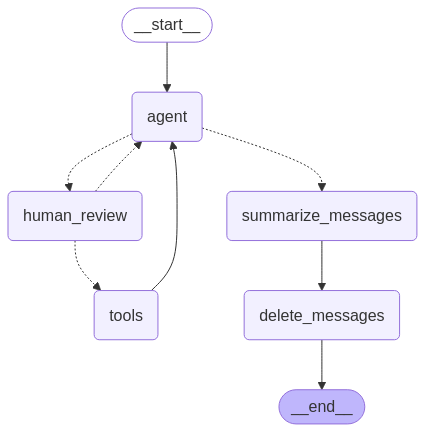

In [112]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

#### continue test

In [97]:
config = {
    'configurable':{
        'thread_id': 'paper_summary2'
    }
}

query = '트럼프의 최근 관세 정책에 대해 알려줘'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary' : ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

트럼프의 최근 관세 정책에 대해 알려줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_qy0a)
 Call ID: call_qy0a
  Args:
    query: trump recent tariff policy


In [98]:
graph.get_state(config).next


('human_review',)

In [99]:
# 대기 상태에서 진행시키기

for chunk in graph.stream(
    Command(resume={'action':'continue'}),
    config=config,
    stream_mode='updates' # values 아니고 updates
):
    print(chunk)


{'human_review': None}
{'tools': {'messages': [ToolMessage(content="The European Union, for example, punched back against Trump's tariffs on steel and aluminum by taxing U.S. products, from bourbon to Harley-Davidson motorcycles. Likewise, China responded to Trump's trade war by slapping tariffs on American goods, including soybeans and pork in a calculated drive to hurt his supporters in farm country. President Joe Biden largely preserves most of the tariffs Trump previously enacted against China, but his administration claims to take a more targeted approach.. In October 2022, he issues sweeping new restrictions on selling semiconductors and chipmaking equipment to China. These curbs will be expanded in October 2023 and December 2024 — when China responds with a ban of U.S. exports for ... NEW YORK (AP) — U.S. President Donald Trump's long-threatened tariffs are here, plunging the country into an escalating trade war with China, Canada and Mexico. Trump's 25% tariffs on imports from 

#### update args 테스트

In [104]:
config = {
    'configurable':{
        'thread_id': 'paper_summary2'
    }
}

query = 'llm survey 논문 내용 검색해서 요약해라'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary' : ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

llm survey 논문 내용 검색해서 요약해라
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_bv53)
 Call ID: call_bv53
  Args:
    query: llm survey


In [105]:
graph.get_state(config).next


('human_review',)

In [106]:
# 대기 상태에서 진행시키기

for chunk in graph.stream(
    Command(resume={'action':'update_args', 'data':{'query':'Large Language Model: A Survey'}}),
    config=config,
    stream_mode='updates' # values 아니고 updates
):
    print(chunk)


{'human_review': {'messages': [{'id': 'run-2dc6acb2-12a7-40a1-9df9-2f9fb26b0636-0', 'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_bv53', 'name': 'arxiv', 'args': {'query': 'Large Language Model: A Survey'}}]}]}}
{'tools': {'messages': [ToolMessage(content='Published: 2024-12-09\nTitle: Questioning the Survey Responses of Large Language Models\nAuthors: Ricardo Dominguez-Olmedo, Moritz Hardt, Celestine Mendler-Dünner\nSummary: Surveys have recently gained popularity as a tool to study large language\nmodels. By comparing survey responses of models to those of human reference\npopulations, researchers aim to infer the demographics, political opinions, or\nvalues best represented by current language models. In this work, we critically\nexamine this methodology on the basis of the well-established American\nCommunity Survey by the U.S. Census Bureau. Evaluating 43 different language\nmodels using de-facto standard prompting methodologies, we establish two\ndominant patterns. Fir

In [107]:
graph.get_state(config).next


('human_review',)

In [108]:
# 대기 상태에서 진행시키기

for chunk in graph.stream(
    Command(resume={'action':'continue'}),
    config=config,
    stream_mode='updates' # values 아니고 updates
):
    print(chunk)


{'human_review': None}
{'tools': {'messages': [ToolMessage(content='This paper provides a comprehensive survey of the latest research on multilingual large language models (MLLMs). MLLMs not only are able to understand and generate language across linguistic boundaries, but also represent an important advancement in artificial intelligence. We first discuss the architecture and pre-training objectives of MLLMs, highlighting the key components and methodologies ... The rapid advancement of artificial intelligence, particularly with the development of Large Language Models (LLMs) built on the transformer architecture, has redefined the capabilities of natural language processing. These models now exhibit remarkable performance across various language-related tasks, such as text generation, question answering, translation, and summarization, often rivaling ... In recent years, the rapid advancement of Large Language Models (LLMs) has transformed the landscape of scientific research, offer

#### update tool 테스트 

In [128]:
config = {
    'configurable':{
        'thread_id': 'paper_summary2'
    }
}

query = 'llm survey 논문 내용 검색해서 요약해라'
for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary' : ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

llm survey 논문 내용 검색해서 요약해라
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_rjn6)
 Call ID: call_rjn6
  Args:
    query: llm survey 논문


In [129]:
graph.get_state(config).next


('human_review',)

In [130]:
# 대기 상태에서 진행시키기

for chunk in graph.stream(
    Command(resume={'action':'update_tool', 'data':{'query':'arxiv말고 duckduckgo 검색해라'}}),
    config=config,
    stream_mode='updates' # values 아니고 updates
):
    print(chunk)


{'human_review': {'messages': [{'tool_call_id': 'call_rjn6', 'name': 'arxiv', 'role': 'tool', 'content': {'query': 'arxiv말고 duckduckgo 검색해라'}}]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7rsv', 'function': {'arguments': '{"query":"llm survey 논문 요약 "}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 1435, 'total_tokens': 1489, 'completion_time': 0.098181818, 'prompt_time': 0.079765208, 'queue_time': 0.039715293, 'total_time': 0.177947026}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b6863a96-e31c-4d58-897d-e3f05f231f55-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'llm survey 논문 요약 '}, 'id': 'call_7rsv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1435, 'output_tokens': 54, 'total_tokens': 1489})]}}
{'__interrupt__': (Interrupt(value={'question

In [131]:
graph.get_state(config).next


('human_review',)

In [132]:
# 대기 상태에서 진행시키기

for chunk in graph.stream(
    Command(resume={'action':'continue'}),
    config=config,
    stream_mode='updates' # values 아니고 updates
):
    print(chunk)


{'human_review': None}
{'tools': {'messages': [ToolMessage(content='논문 리뷰/Survey 논문 ... 보고된 LLM 평가 결과를 요약. - Section VII: LLM 연구의 과제와 미래 연구 방향을 요약하며 논문을 마무리. 2 Large Language Models. 이 섹션에서는 LLM의 기반이 되는 초기 사전 학습 신경 언어 모델(Pre-trained Neural Language Models)을 검토하고, 이어서 GPT ... LLM을 위한 긴 컨텍스트 대 RAG: 평가 및 재검토 / Long Context vs. RAG for LLMs: An Evaluation and Revisits 논문 소개. RAG 시스템과 비교하여 긴 문맥(LC) LLM을 종합적으로 평가한 결과, 세 가지 주요 결과는 다음과 같습니다: 1) 질문-답변 벤치마크에서 LC가 일반적으로 RAG보다 성능이 뛰어남, 2) 요약 기반 검색은 LC와 ... 요약 및 의의. LLM 기반 자율 에이전트 연구는 다양한 응용 ... LLM 기반 자율 에이전트의 현재 상태와 트렌드를 포괄적으로 정리한 서베이 논문(Survey Paper)입니다. 논문이 다루는 주요 내용은 다음과 같습니다: 1. 첫 번째 Planning Survey논문이라네요. Task Decomposition은 분할 정복의 아이디어를 채택하여 복잡한 작업을 여러 개의 하위 작업으로 분해, 각 하위 작업에 대해 순차적으로 계획하여 진행합니다.. Task Decomposition . Multi-plan Selection는 LLM이 더 많은 생각을 진행할 수 있도록 진행하고, 작업에 대한 다양한 대안 ... 인공지능/논문 리뷰 or 진행. A survey on LLM-based multi-agent systems: workflow, infrastructure, and challenges - 논문 리뷰 ... 요약. LLM 기반 MAS는 여전히 도전 과제가 존재하지만, 복잡한 문제를 

In [133]:
graph.get_state(config).values['messages'][-1].pretty_print()


================================== Ai Message ==================================

다음은 LLM survey 논문 내용 요약입니다.

* **LLM의 기반이 되는 초기 사전 학습 신경 언어 모델(Pre-trained Neural Language Models)을 검토**하고, 이어서 GPT 등의 LLM을 소개합니다.
* **질문-답변 벤치마크에서 긴 문맥(LC) LLM이 RAG보다 성능이 뛰어남**을 보고 합니다.
* **LLM 기반 자율 에이전트 연구를 다룹니다.**
* **LLM 기반 자율 에이전트의 현재 상태와 트렌드를 포괄적으로 정리**한 서베이 논문입니다.
